In [6]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn import svm
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import Imputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import AdaBoostClassifier
# from auto_ml import Predictor

def eval_tree_based_model_max_depth(clf, max_depth, X_train, y_train, X_test, y_test):
    """
    This function evaluates the given classifier (either a decision tree or random forest) at all of the 
    maximum tree depth parameters in the vector max_depth, using the given training and testing
    data. It returns two vector, with the training and testing classification errors.
    
    Inputs:
        clf: either a decision tree or random forest classifier object
        max_depth: a (T, ) vector of all the max_depth stopping condition parameters 
                            to test, where T is the number of parameters to test
        X_train: (N, D) matrix of training samples.
        y_train: (N, ) vector of training labels.
        X_test: (N, D) matrix of test samples
        y_test: (N, ) vector of test labels
    Output:
        train_err: (T, ) vector of classification errors on the training data
        test_err: (T, ) vector of classification errors on the test data
    """
    training_errors = []
    test_errors = []
    # evaluates the tree classifier for the desired number of max_tree_depth values values 
    for i in range(len(max_depth)):
        print(max_depth[i])
        clf.set_params(min_samples_leaf = max_depth[i])
        clf.fit(X_train, y_train)
        y_train_predict = clf.predict_proba(X_train)[:, 1]
        y_test_predict = clf.predict_proba(X_test)[:,1]
        
        training_errors.append(roc_auc_score(y_train, y_train_predict))
        test_errors.append(roc_auc_score( y_test, y_test_predict))
    return np.array(training_errors), np.array(test_errors)

def classification_err(y, real_y):
    """
    This function returns the classification error between two equally-sized vectors of 
    labels; this is the fraction of samples for which the labels differ.
    
    Inputs:
        y: (N, ) shaped array of predicted labels
        real_y: (N, ) shaped array of true labels
    Output:
        Scalar classification error
    """
    return sum(y != real_y)/len(y)



In [4]:
data = np.loadtxt(open("train_2008.csv", "rb"), delimiter=",", skiprows=1)
test_data = np.loadtxt(open("test_2008.csv", "rb"), delimiter=",", skiprows=1)

X = data[:, 3:382]
y = data[:, 382]
print(y)
X_test = test_data[:, 3:382]



[0. 0. 0. ... 0. 0. 0.]


In [54]:
sum(X[:, 10]<0)
print(i_love_indices)
print(len(i_love_indices))
to_delete = [1,2,3,4,5]
print(np.delete(i_love_indices, to_delete[2:]))

[ 43  36   8   3 338 196 333 191  34 198 322 330  52 337 230  10 234 336
  25 233  26  38 332 231  27 324 189 260  47 249 327 321  61 235 320 236
  32 326  44  13  28 319 341 226 194 323  12  14 335   4  59  49 363  56
  33  55  29  50  15  62  45  94  24 229  54  71 186 354  92  16 156  18
 175  40 232  60 360  83   0  57  51  80 353 228 187 176 184 357 364 160
  39  30  69  70 167 334  48 179 329 213 361 276 352  67 163 288   5  17
  65  74 343 181 318 210 246  88  19 172 173  75 174 223 180 162 356   7
 270 251  41 351  90  98 102 225  35 224 159 269  20 362 114 331 158 134
 261  97 204 272 142 209  86 349 157 151   1 242 328 227 275 296 316 355
 166 271 315  89 100 298  84 350 274 206 307 103 263 262 348 311  99   6
 308 265 317  31 203 268 183 266 101 168 325  72  37  78 313 273 201 300
 154 219 237 264 202 290 254  96 221 310 309 306 314 305 164 289 220 312
 205 132 182 299  87 358 292 212 238 301 291 293  91 282  46 295 165 359
 294 115 283 297 286 222 245 127 281  63 152 129 26

In [28]:
X[X < 0] = -1
print(X.shape)
print(X_test.shape)
bad_indices = []
real_bad_indices = []
for i in range(np.shape(X)[1]):
    num_less = X[:,i] < 0
    #bad_indices.append(float(sum(num_less))/float(len(num_less)))
    if sum(num_less)/len(num_less) == 1:
        real_bad_indices.append(i)
        
print(real_bad_indices)
# print(bad_indices[45])

real_bad_indices_2 = []
for i in range(np.shape(X_test)[1]):
    num_less = X_test[:,i] < 0
    if sum(num_less)/len(num_less) == 1:
        real_bad_indices_2.append(i)
            
print(real_bad_indices_2)  
X = np.delete(X, real_bad_indices, axis = 1)
X_test = np.delete(X_test, real_bad_indices,axis = 1)
print(X.shape)
print(X_test.shape)
imp = Imputer(missing_values=-1, strategy='mean')
X = imp.fit_transform(X)
imp = Imputer(missing_values=-1, strategy='mean')
X_test = imp.fit_transform(X_test)
print(X.shape)
print(X_test.shape)

(64667, 379)
(16000, 379)
[9, 11, 126, 127, 128, 132, 133, 134]
[9, 10, 11, 124, 125, 126, 127, 128, 131, 132, 133, 134, 215]
(64667, 371)
(16000, 371)
(64667, 371)
(16000, 366)


In [1]:
real_bad_indices_2 = [9, 10, 11, 124, 125, 126, 127, 128, 131, 132, 133, 134, 215]
print(len(real_bad_indices_2))


13


0.7
(64667, 366)
[0.50009185 0.49680024 0.50183294 ... 0.49355935 0.49833579 0.49782501]
0.7799999999999999
(64667, 366)
[0.50013275 0.49720663 0.50087196 ... 0.4934204  0.49831911 0.49810698]
0.8599999999999999
(64667, 366)
[0.50014657 0.49740105 0.50095911 ... 0.49400444 0.49837554 0.49813087]
0.9399999999999998
(64667, 366)
[0.50013369 0.49735247 0.50109044 ... 0.49486111 0.49856643 0.49841959]
1.0199999999999998
(64667, 366)
[0.5001805  0.4979969  0.50119472 ... 0.49511274 0.49876123 0.49835059]
1.0999999999999996
(64667, 366)
[0.50041277 0.49812482 0.50121049 ... 0.49507431 0.49904165 0.49868011]
1.1799999999999997
(64667, 366)
[0.50036058 0.49826294 0.5007149  ... 0.49527453 0.49895607 0.49867553]


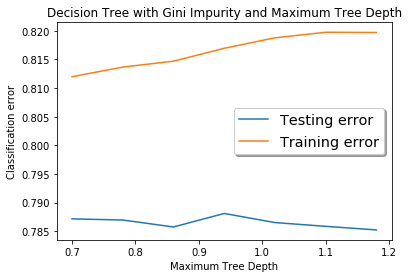

Test error minimized at max_depth = 0.7881045681903884 0.9399999999999998
[0.7871658533419221, 0.7869593542001841, 0.7857446717487082, 0.7881045681903884, 0.7865146060486686, 0.7858584525258068, 0.7852320488792969]


In [25]:
# kf = KFold(n_splits = 5, shuffle = True) 

# all_predictions = np.zeros(5)
# for train_index, test_index in kf.split(X):
#     # print("TRAIN:", train_index, "TEST:", test_index)
#     X_train, X_val = X[train_index], X[test_index]
#     y_train, y_val = y[train_index], y[test_index]
    
#     #fprint(np.shape(y_test))
#     scaler = StandardScaler()
#     # Fit on training set only.
#     scaler.fit(X_train)
#     # Apply transform to both the training set and the test set.
#     X_train = scaler.transform(X_train)
#     X_val = scaler.transform(X_val)


training_errors = []
test_errors = []
max_depth = np.arange(0.7, 1.2, 0.08)
for est in max_depth:
#    
#     max_depth = np.arange(15,200,15)
#     for est in max_depth:
        #print(slices, est)

    X = data[:, 3:382]
    y = data[:, 382]
    print(est)
    X[X < 0] = -1
    X = np.delete(X, real_bad_indices_2, axis = 1)
    imp = Imputer(missing_values=-1, strategy='mean')
    X = imp.fit_transform(X)
    #X = np.delete(X, i_love_indices[len(i_love_indices) - 250:], axis=1)

    print(X.shape)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # scaler = StandardScaler()
    # scaler.fit(X)
    # X_train = scaler.transform(X_train)
    # X_test = scaler.transform(X_test)

    # pca = PCA(n_components = 75)
    # pca.fit(X_train)
    # X_train = pca.transform(X_train)
    # X_test = pca.transform(X_test)
    #      #X_val = pca.transform(X_val)

    # print('PCA done')
    clf1 = RandomForestClassifier(max_depth = 2, min_samples_leaf = 20)
    # clf = svm.SVC(probability = True, verbose=True)

    clf = AdaBoostClassifier(base_estimator = clf1, n_estimators = 190, learning_rate = est)

    clf.fit(X_train, y_train)
    # print('SVM done')
    #     print(clf.classes_)
    #clf.fit(X, y)

    #     predictions = clf.predict_proba(X_val)[:, 1]
    #     print(sum(np.floor(2.0*predictions) != np.array(y_val))/len(predictions))
    #     print(roc_auc_score(y_val, predictions))
    #     importances = clf.feature_importances_
    #     indices = np.argsort(importances)[::-1]
    #     #Print the feature ranking
    #     print("Feature ranking:")
    #     for f in range(X.shape[1]):
    #         print("%d. feature %d (%f)" % (f, indices[f], importances[indices[f]]))
    #         #print(X_train[:, indices[f]])


    #print(1) 
    #max_depth = np.arange(10, 200, 20)
    #train_err, test_err = eval_tree_based_model_max_depth(clf, max_depth, X_train, y_train, X_val, y_val)


    y_train_predict = clf.predict_proba(X_train)[:, 1]
    y_test_predict = clf.predict_proba(X_test)[:,1]

    training_errors.append(roc_auc_score(y_train, y_train_predict))
    test_errors.append(roc_auc_score(y_test, y_test_predict))
    
    results = clf.predict_proba(X_test)
    print(results[:, 1])


plt.figure()
plt.plot(max_depth, test_errors, label='Testing error')
plt.plot(max_depth, training_errors, label='Training error')
plt.xlabel('Maximum Tree Depth')
plt.ylabel('Classification error')
plt.title('Decision Tree with Gini Impurity and Maximum Tree Depth')
plt.legend(loc=0, shadow=True, fontsize='x-large')
plt.show()

print('Test error minimized at max_depth =', np.max(test_errors), max_depth[np.argmax(test_errors)])
print(test_errors)



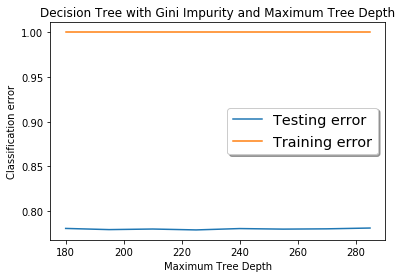

Test error minimized at max_depth = 0.7811935031645026 285
[0.7790570432941638, 0.7785818265192835, 0.7808646139064485, 0.7798827898621545, 0.7797951339764745, 0.7797162280544273, 0.7807279894742938, 0.7801513199960762, 0.7807501143823371, 0.7794381510851845, 0.7800824140324667, 0.7790893869097356, 0.7805945056540857, 0.7799728519878338, 0.7802944912760206, 0.7811935031645026]


In [90]:
plt.figure()
plt.plot(max_depth, test_errors[8:], label='Testing error')
plt.plot(max_depth, training_errors[8:], label='Training error')
plt.xlabel('Maximum Tree Depth')
plt.ylabel('Classification error')
plt.title('Decision Tree with Gini Impurity and Maximum Tree Depth')
plt.legend(loc=0, shadow=True, fontsize='x-large')
plt.show()
print('Test error minimized at max_depth =', np.max(test_errors[8:]), max_depth[np.argmax(test_errors[8:])])
print(test_errors)

In [26]:
#ACTUAL MODEL CODE

data = np.loadtxt(open("train_2008.csv", "rb"), delimiter=",", skiprows=1)
test_data = np.loadtxt(open("test_2008.csv", "rb"), delimiter=",", skiprows=1)

X = data[:, 3:382]
y = data[:, 382]

X_test = test_data[:, 3:382]

X[X < 0] = -1
X = np.delete(X, real_bad_indices_2, axis = 1)
imp = Imputer(missing_values=-1, strategy='mean')
X = imp.fit_transform(X)

X = np.delete(X, i_love_indices[len(i_love_indices) - 250:], axis=1)


#X_test[X_test < 0] = -1
X_test = np.delete(X_test, real_bad_indices_2,axis = 1)
imp = Imputer(missing_values=-1, strategy='mean')
X_test = imp.fit_transform(X_test)

X_test = np.delete(X_test, i_love_indices[len(i_love_indices) - 250:], axis=1)


# scaler = StandardScaler()
# scaler.fit(X)
# X = scaler.transform(X)
# X_test = scaler.transform(X_test)

# pca = PCA(n_components = 75)
# pca.fit(X)
# X = pca.transform(X)
# X_test = pca.transform(X_test)

# #print(X.shape)

clf1 = RandomForestClassifier(max_depth = 2, min_samples_leaf = 20)
clf = AdaBoostClassifier(base_estimator = clf1, n_estimators = 190)
clf.fit(X, y)

# importances = clf.feature_importances_
# indices = np.argsort(importances)[::-1]
# #Print the feature ranking
# print("Feature ranking:")
# for f in range(X.shape[1]):
#     print("%d. feature %d (%f)" % (f, indices[f], importances[indices[f]]))
#     #print(X_train[:, indices[f]])
    
# i_love_indices = indices

results = clf.predict_proba(X_test)





In [ ]:
# df_train = pd.DataFrame(data = X)
# df_test = pd.DataFrame(data = X_test)

# ml_predictor = Predictor(type_of_estimator='classifier', column_descriptions=column_descriptions)
# ml_predictor.train(df_train)
# ml_predictor.predict(df_test)


In [27]:
new_results = results[:, 1]
#new_results[new_results < 0.03] = 0
#new_results[new_results > 0.67] = 1
with open('output_1.csv', 'w') as output:
    output.write('id,target\n')
    for i in range(len(test_data)):
        output.write(str(int(test_data[i][0])) + ',' + str(new_results[i]) + '\n')



In [117]:
test = np.copy(results[:, 1])

test.sort()
print(test[::-1][:180])

[0.8198093  0.80898397 0.79962917 0.79021625 0.78625062 0.78174169
 0.77853367 0.77287553 0.77251965 0.76782463 0.76634991 0.76543805
 0.76533352 0.76396577 0.76154461 0.75544078 0.75501377 0.75472866
 0.7546399  0.75458857 0.75358048 0.75243728 0.75224463 0.7498976
 0.74829219 0.74430351 0.74257807 0.74173416 0.74158917 0.74113962
 0.73908588 0.73775042 0.73564811 0.73533103 0.73526861 0.73502455
 0.73359814 0.73351175 0.73261683 0.73128456 0.72906647 0.72233281
 0.72222513 0.7200193  0.7192253  0.71918656 0.71897341 0.71838145
 0.71754991 0.71695955 0.71683241 0.71653549 0.71561504 0.71463297
 0.7145744  0.71417955 0.71383217 0.71223372 0.71113641 0.71004102
 0.70977054 0.70806521 0.7076079  0.70668292 0.70667916 0.70656725
 0.70564052 0.70539752 0.70490761 0.70478262 0.70475867 0.70447995
 0.70446921 0.70346516 0.70319091 0.70317852 0.70299224 0.70291811
 0.70213975 0.70203857 0.70186658 0.70141378 0.70111054 0.7006842
 0.70051245 0.70028475 0.69987121 0.69960211 0.69884543 0.698783

In [124]:
print(i_love_indices)

[ 42  35   8 333   3 194 187 328 192  33 317 325  37   9  51 225 229 228
  24 331  25 327  26 332 226 244 322 255 185 319 321 230  31  46 231 318
  12 221  43  60 315 336 190  11  27 316  13  58  48  32   4 358  55  53
 224  14  28  49  61  93 330  70  54  23  44  91 355 152  59 171  17  50
  15  56  39 314 227 180 182  79   0 348  82 223 349 172 352 359 183  69
 324 156  38  66 163 313  29  73 356 241 175  68  74 329   5 170 208  47
 159 205 218 347  18  16 169 283 176 168  87 338 177 271 357 158   7  40
 220 246  97  89 204 155 138 222 101  19  64 265 346 270  34 200 219 344
 326 113   1  88 264  83 351 102 343 266 237 312  96   6 306 147 311 258
 153 295  99 320 162 261 154 285 256 302 202 310 164  30  85 267 130 263
  95 291 350 293 345  71  36 269 197  98 303 100 260 232 179 305 323 294
  77 214 259 308 160 296 249 215 284 304 309 128 198 207 199  86 257 150
 268 287 286 307 300 353 201 354 216 301 233 178  90 289  45 288 290 114
 282 123 277 292 217  62 161  20   2 240 129 262 27